# Landscape or Cityscape?

The idea behind this notebook is to test out various CNNs to determine which networks are best suited to determining if an picture is an image of a city or an image of nature. My data sources for this experiment are the subreddits r/earthporn and r/cityporn. I chose these subreddits as they are focused and fairly strictly moderated. Each contains only aestetically pleasing pictures of landscapes and cityscapes respectively. I took all the directly linked images from these subreddits since 1/1/17 that have over a certain threshold of upvotes, which gave me a few thousand images that are almost entirely either a picture of a natural landscape or a picture of a cityscape

I will use keras' implementations of VGG16, InceptionV3 and ResNet50 as feature extration (the layers will not be altered during training) and feed that into small fully connected network. As an experiment I will use both one dense layer and two dense layers for each base model to see if this effects their performance.

In [1]:
#general imports and commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import keras
%matplotlib inline
%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [2]:
#keras specific imports
from keras import Model, Input
from keras.layers import Dense, Flatten,GlobalMaxPool2D
from keras.models import Sequential
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

from keras.applications import VGG16,vgg16
from keras.applications import ResNet50, resnet50
from keras.applications import InceptionV3, inception_v3

In [ ]:
#functions for the project that I put in a .py to clean up the notebook
from importlib import reload
import project_utils
reload(project_utils)

In [4]:
#loading pretrained model weights
VGG = VGG16(weights = 'imagenet', include_top = False, input_shape= (224,224,3))

RN50 = ResNet50(weights = 'imagenet', include_top = False, input_shape= (224,224,3))

IV3 = InceptionV3(weights = 'imagenet', include_top = False, input_shape= (224,224,3))

The first base model I will try is [VGG16](https://arxiv.org/abs/1409.1556). I will remove the top layers of the network, keeping only the convolutions as feature extraction, then max pool these features before feeding them into two fully connected layers and a softmax output layer

In [5]:
# This function takes in headless model (some pretrained CNN)
# and adds a max pooling and a dense fully connected layer to it.
def create_model1(base_layers):
    for layer in base_layers.layers:
        layer.trainable = False
    X = base_layers.output
    X = GlobalMaxPool2D()(X)
    X = Dense(100, activation = 'relu',name = '1')(X)
    predictions = Dense(2 , activation = 'softmax',name = '2')(X)
    model = Model(inputs = base_layers.inputs, outputs = predictions)
    return model

#same as the first function but there are two dense layers rather than just one 
def create_model2(base_layers):
    for layer in base_layers.layers:
        layer.trainable = False
    X = base_layers.output
    X = GlobalMaxPool2D()(X)
    X = Dense(200, activation = 'relu', name = '1')(X)
    X = Dense(100, activation = 'relu',name = '2')(X)
    predictions = Dense(2 , activation = 'softmax',name = '3')(X)
    model = Model(inputs = base_layers.inputs, outputs = predictions)
    return model
    

In [6]:
#Preparing data generators
#this keras utilitiy will continously generate images that have been slightly rotated 
#or shifted or flipped from the directories where I stored the images for both training and validation
data_gen = ImageDataGenerator(shear_range= 0.2,
                                    zoom_range= 0.2,
                                    horizontal_flip= True,
                                    width_shift_range=0.2,
                                    height_shift_range = 0.2,
                                    preprocessing_function= (lambda x: x/127.5 - 1))                                           

train_generator = data_gen.flow_from_directory('./images/train', target_size= (224,224), class_mode= 'categorical')
validation_generator = data_gen.flow_from_directory('./images/validation', target_size= (224,224), class_mode= 'categorical')

vgg_model1 = create_model1(VGG)

vgg_model1.compile(optimizer='rmsprop',loss = 'categorical_crossentropy',metrics = ['accuracy'])

vgg_model2 = create_model2(VGG)

vgg_model2.compile(optimizer='rmsprop',loss = 'categorical_crossentropy',metrics = ['accuracy'])

Found 4850 images belonging to 2 classes.
Found 605 images belonging to 2 classes.


In [7]:
#this will cause the model to stop fitting if the validation loss has gone down for 3 epochs
#this is to prevent overfitting by training the model for too long
early_stopping = EarlyStopping(min_delta = .01, 
                               patience = 3,
                               verbose = 1,
                               mode = 'min')

In [8]:
vgg_model1.fit_generator(generator = train_generator, 
                        epochs=20,
                        steps_per_epoch= 20, #there are 32 images per step so this is 64 per epoch
                        callbacks = [early_stopping],
                        validation_data = validation_generator,
                        validation_steps=10) #validation on 320 images

Epoch 1/20
10/20 [==============>...............] - ETA: 51s - loss: 0.8661 - acc: 0.6375

/home/ubuntu/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (98130452 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


20/20 [==============================] - 107s 5s/step - loss: 0.6146 - acc: 0.7531 - val_loss: 0.3635 - val_acc: 0.8438
Epoch 2/20
 1/20 [>.............................] - ETA: 52s - loss: 0.3419 - acc: 0.8750

/home/ubuntu/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (93153600 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


20/20 [==============================] - 104s 5s/step - loss: 0.3038 - acc: 0.8844 - val_loss: 0.2918 - val_acc: 0.8738
Epoch 3/20
20/20 [==============================] - 92s 5s/step - loss: 0.2897 - acc: 0.8859 - val_loss: 0.5440 - val_acc: 0.8438
Epoch 4/20
20/20 [==============================] - 107s 5s/step - loss: 0.2152 - acc: 0.9238 - val_loss: 0.2462 - val_acc: 0.9243
Epoch 5/20
20/20 [==============================] - 87s 4s/step - loss: 0.2269 - acc: 0.9234 - val_loss: 0.1928 - val_acc: 0.9219
Epoch 6/20
20/20 [==============================] - 113s 6s/step - loss: 0.2469 - acc: 0.9047 - val_loss: 0.3927 - val_acc: 0.8927
Epoch 7/20
20/20 [==============================] - 85s 4s/step - loss: 0.2287 - acc: 0.9234 - val_loss: 0.3864 - val_acc: 0.8156
Epoch 8/20
20/20 [==============================] - 121s 6s/step - loss: 0.2104 - acc: 0.9219 - val_loss: 0.2040 - val_acc: 0.9306
Epoch 00008: early stopping


In [9]:
vgg_model2.fit_generator(generator = train_generator, 
                        epochs=20,
                        steps_per_epoch= 20, #there are 32 images per step so this is 64 per epoch
                        callbacks = [early_stopping],
                        validation_data = validation_generator,
                        validation_steps=10) #validation on 320 images


Epoch 1/20
10/20 [==============>...............] - ETA: 50s - loss: 0.7736 - acc: 0.7750

/home/ubuntu/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (98130452 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


20/20 [==============================] - 102s 5s/step - loss: 0.5391 - acc: 0.8375 - val_loss: 0.3421 - val_acc: 0.8594
Epoch 2/20
 1/20 [>.............................] - ETA: 44s - loss: 0.4068 - acc: 0.8438

/home/ubuntu/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (93153600 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


20/20 [==============================] - 106s 5s/step - loss: 0.3107 - acc: 0.8875 - val_loss: 0.2909 - val_acc: 0.8959
Epoch 3/20
20/20 [==============================] - 94s 5s/step - loss: 0.2431 - acc: 0.9125 - val_loss: 0.3530 - val_acc: 0.8812
Epoch 4/20
20/20 [==============================] - 108s 5s/step - loss: 0.2505 - acc: 0.9156 - val_loss: 0.3955 - val_acc: 0.8076
Epoch 5/20
20/20 [==============================] - 89s 4s/step - loss: 0.2801 - acc: 0.8875 - val_loss: 0.2688 - val_acc: 0.9094
Epoch 6/20
20/20 [==============================] - 109s 5s/step - loss: 0.1841 - acc: 0.9406 - val_loss: 0.1211 - val_acc: 0.9621
Epoch 7/20
20/20 [==============================] - 78s 4s/step - loss: 0.2668 - acc: 0.9042 - val_loss: 0.1803 - val_acc: 0.9375
Epoch 8/20
20/20 [==============================] - 117s 6s/step - loss: 0.2454 - acc: 0.9078 - val_loss: 0.2533 - val_acc: 0.9022
Epoch 9/20
20/20 [==============================] - 84s 4s/step - loss: 0.1825 - acc: 0.9297 - va

In [10]:
#makes and evalutes the model on the test set
X_test, y_test = project_utils.get_test('_3_10','vgg16')

In [11]:
#Evaluate 1 layer top
project_utils.evaluate_and_confusion_matrix(X_test,y_test, vgg_model1)

605/605 [==============================] - 5s 9ms/step
accuracy: 0.9570247933884297, loss: 0.14508889652480764 
ROC AUC score: 0.9699846390168971
f1 score:  0.972631578947
columns are actual, rows are predicted
         city  earth  totals
city    117.0    3.0   120.0
earth    23.0  462.0   485.0
totals  140.0  465.0   605.0


In [12]:
#Evaluate 2 layer top
project_utils.evaluate_and_confusion_matrix(X_test,y_test, vgg_model2)

605/605 [==============================] - 5s 8ms/step
accuracy: 0.9553719008264463, loss: 0.14391904058288937 
ROC AUC score: 0.9694930875576037
f1 score:  0.97124600639
columns are actual, rows are predicted
         city  earth  totals
city    122.0    9.0   131.0
earth    18.0  456.0   474.0
totals  140.0  465.0   605.0


In [15]:
#function to help with error analysis and sanity checking
def show_and_predict(path,model1,model2,modelname):
    pylab.imshow(pylab.imread(path))
    prepped = project_utils.prep_for_model(path,modelname)
    pred = model1.predict(prepped)
    pred2 = model2.predict(prepped)
    print("Model1:")
    print("p(city): {}, p(nature): {}".format(pred[0,0],pred[0,1]))
    print("Model2")
    print("p(city): {}, p(nature): {}".format(pred2[0,0],pred2[0,1]))

    

Model1:
p(city): 0.9983295798301697, p(nature): 0.0016703724395483732
Model2
p(city): 0.9997716546058655, p(nature): 0.00022840779274702072


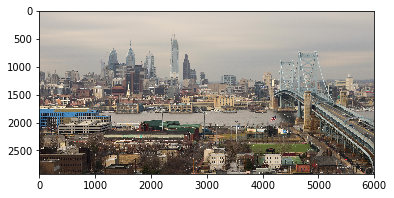

In [16]:
show_and_predict('images/test/cityporn_3_10/image229.jpg',vgg_model1,vgg_model2,'vgg16')

Model1:
p(city): 0.000578820938244462, p(nature): 0.999421238899231
Model2
p(city): 0.004912516567856073, p(nature): 0.9950874447822571


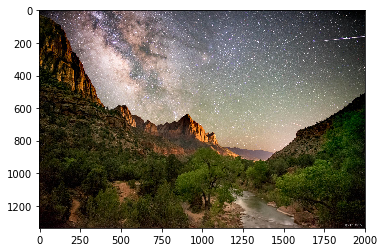

In [17]:
show_and_predict('images/test/earthporn_3_10/image3077.jpg',vgg_model1,vgg_model2,'vgg16')

Model1:
p(city): 0.961635172367096, p(nature): 0.03836478665471077
Model2
p(city): 0.9864845871925354, p(nature): 0.013515481725335121


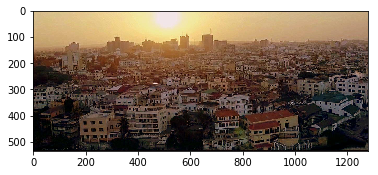

In [18]:
show_and_predict('images/test/cityporn_3_10/image971.jpg',vgg_model1,vgg_model2,'vgg16')

This network is doing pretty well! Its at about 95% accuracy between the classes and the loss is fairly low. Still, it is worth it to try out some other base layers to see if we can do even better. The next base network that I will try out is [Inception V3](https://arxiv.org/abs/1512.00567)

In [25]:
iv3_model1 = create_model1(IV3)
iv3_model2 = create_model2(IV3)

In [26]:
data_gen = ImageDataGenerator(shear_range= 0.2,
                                    zoom_range= 0.2,
                                    horizontal_flip= True,
                                    width_shift_range=0.2,
                                    height_shift_range = 0.2,
                                    preprocessing_function= project_utils.preprocess_IV3)                                           

train_generator = data_gen.flow_from_directory('./images/train', target_size= (224,224), class_mode= 'categorical')
validation_generator = data_gen.flow_from_directory('./images/validation', target_size= (224,224), class_mode= 'categorical')




Found 4850 images belonging to 2 classes.
Found 605 images belonging to 2 classes.


In [27]:
iv3_model1.compile(optimizer='rmsprop',loss = 'categorical_crossentropy',metrics = ['accuracy'])
iv3_model1.fit_generator(generator = train_generator, 
                        epochs=20,
                        steps_per_epoch= 20, #there are 32 images per step so this is 64 per epoch
                        callbacks = [early_stopping],
                        validation_data = validation_generator,
                        validation_steps=10) #validation on 320 images

Epoch 1/20
 2/20 [==>...........................] - ETA: 1:36 - loss: 1.7827 - acc: 0.6094

/home/ubuntu/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (93153600 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


 6/20 [========>.....................] - ETA: 1:14 - loss: 2.5251 - acc: 0.7500

/home/ubuntu/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (98130452 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


20/20 [==============================] - 108s 5s/step - loss: 3.4523 - acc: 0.7578 - val_loss: 3.9288 - val_acc: 0.7562
Epoch 2/20
20/20 [==============================] - 99s 5s/step - loss: 3.6491 - acc: 0.7736 - val_loss: 3.6100 - val_acc: 0.7760
Epoch 3/20
20/20 [==============================] - 100s 5s/step - loss: 3.9288 - acc: 0.7562 - val_loss: 3.6769 - val_acc: 0.7719
Epoch 4/20
20/20 [==============================] - 112s 6s/step - loss: 3.7525 - acc: 0.7672 - val_loss: 3.6609 - val_acc: 0.7729
Epoch 5/20
20/20 [==============================] - 86s 4s/step - loss: 3.6014 - acc: 0.7766 - val_loss: 3.5762 - val_acc: 0.7781
Epoch 6/20
20/20 [==============================] - 115s 6s/step - loss: 3.7777 - acc: 0.7656 - val_loss: 4.0168 - val_acc: 0.7508
Epoch 7/20
20/20 [==============================] - 84s 4s/step - loss: 3.9036 - acc: 0.7578 - val_loss: 4.0295 - val_acc: 0.7500
Epoch 8/20
20/20 [==============================] - 116s 6s/step - loss: 3.6014 - acc: 0.7766 - v

In [28]:
iv3_model2.compile(optimizer='rmsprop',loss = 'categorical_crossentropy',metrics = ['accuracy'])
iv3_model2.fit_generator(generator = train_generator, 
                        epochs=20,
                        steps_per_epoch= 20, #there are 32 images per step so this is 64 per epoch
                        callbacks = [early_stopping],
                        validation_data = validation_generator,
                        validation_steps=10) #validation on 320 images

Epoch 1/20
20/20 [==============================] - 98s 5s/step - loss: 3.8466 - acc: 0.7359 - val_loss: 3.8280 - val_acc: 0.7625
Epoch 2/20
 6/20 [========>.....................] - ETA: 1:01 - loss: 2.6024 - acc: 0.8385

/home/ubuntu/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (98130452 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


20/20 [==============================] - 105s 5s/step - loss: 3.3244 - acc: 0.7937 - val_loss: 3.6609 - val_acc: 0.7729
Epoch 3/20
20/20 [==============================] - 92s 5s/step - loss: 4.0295 - acc: 0.7500 - val_loss: 3.8280 - val_acc: 0.7625
Epoch 4/20
20/20 [==============================] - 103s 5s/step - loss: 3.9792 - acc: 0.7531 - val_loss: 3.5592 - val_acc: 0.7792
Epoch 5/20
20/20 [==============================] - 96s 5s/step - loss: 3.3244 - acc: 0.7937 - val_loss: 3.5258 - val_acc: 0.7812
Epoch 6/20
20/20 [==============================] - 120s 6s/step - loss: 3.7525 - acc: 0.7672 - val_loss: 3.8134 - val_acc: 0.7634
Epoch 7/20
 4/20 [=====>........................] - ETA: 9s - loss: 4.0295 - acc: 0.7500

/home/ubuntu/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (93153600 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


20/20 [==============================] - 83s 4s/step - loss: 3.9288 - acc: 0.7562 - val_loss: 4.3821 - val_acc: 0.7281
Epoch 8/20
20/20 [==============================] - 116s 6s/step - loss: 3.5790 - acc: 0.7780 - val_loss: 2.7965 - val_acc: 0.8265
Epoch 9/20
20/20 [==============================] - 79s 4s/step - loss: 3.8532 - acc: 0.7609 - val_loss: 3.8784 - val_acc: 0.7594
Epoch 10/20
20/20 [==============================] - 124s 6s/step - loss: 3.6266 - acc: 0.7750 - val_loss: 3.9151 - val_acc: 0.7571
Epoch 11/20
20/20 [==============================] - 70s 3s/step - loss: 3.6769 - acc: 0.7719 - val_loss: 3.9792 - val_acc: 0.7531
Epoch 00011: early stopping


In [29]:
X_test, y_test = project_utils.get_test('_3_10','inception_v3')

In [30]:
#Evaluate 1 layer top
project_utils.evaluate_and_confusion_matrix(X_test,y_test,iv3_model1)


605/605 [==============================] - 4s 6ms/step
accuracy: 0.768595041322314, loss: 3.7298072872083154 
ROC AUC score: 0.3890706605222734
f1 score:  0.869158878505
columns are actual, rows are predicted
         city  earth  totals
city      0.0    0.0     0.0
earth   140.0  465.0   605.0
totals  140.0  465.0   605.0


In [31]:
#Evaluate 2 layer top
project_utils.evaluate_and_confusion_matrix(X_test,y_test,iv3_model2)


605/605 [==============================] - 3s 6ms/step
accuracy: 0.768595041322314, loss: 3.7298072872083154 
ROC AUC score: 0.39682411674347157
f1 score:  0.869158878505
columns are actual, rows are predicted
         city  earth  totals
city      0.0    0.0     0.0
earth   140.0  465.0   605.0
totals  140.0  465.0   605.0


Model1:
p(city): 6.943026388651888e-35, p(nature): 1.0
Model2
p(city): 1.1353069026046804e-31, p(nature): 1.0


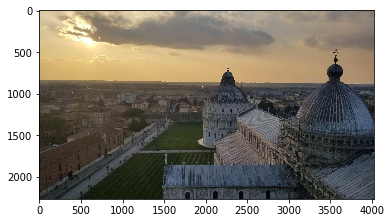

In [32]:
show_and_predict('images/test/cityporn_3_10/image39.jpg',iv3_model1,iv3_model2,'inception_v3')

Model1:
p(city): 1.7818538262397713e-33, p(nature): 1.0
Model2
p(city): 2.0467071929172745e-30, p(nature): 1.0


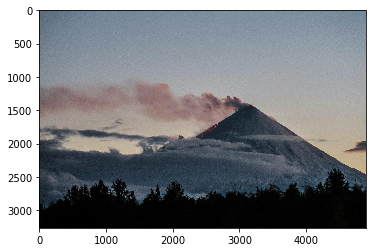

In [33]:
show_and_predict('images/test/earthporn_3_10/image3509.jpg',iv3_model1,iv3_model2,'inception_v3')

Model1:
p(city): 1.5505770346310392e-34, p(nature): 1.0
Model2
p(city): 7.869228647460752e-33, p(nature): 1.0


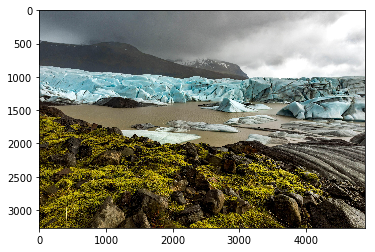

In [35]:
show_and_predict('images/test/earthporn_3_10/image2637.jpg',iv3_model1,iv3_model2,'inception_v3')

Lastly I'll run the same experiment with [ResNet50](https://arxiv.org/abs/1512.03385)



In [36]:
rn50_model1 = create_model1(RN50)
rn50_model2 = create_model2(RN50)


In [37]:
#Preparing data generators
#this keras utilitiy will continously generate images that have been slightly rotated 
#or shifted or flipped from the directories where I stored the images for both training and validation
data_gen = ImageDataGenerator(shear_range= 0.2,
                                    zoom_range= 0.2,
                                    horizontal_flip= True,
                                    width_shift_range=0.2,
                                    height_shift_range = 0.2,
                                    preprocessing_function= (lambda x: x/127.5 - 1))                                           

train_generator = data_gen.flow_from_directory('./images/train', target_size= (224,224), class_mode= 'categorical')
validation_generator = data_gen.flow_from_directory('./images/validation', target_size= (224,224), class_mode= 'categorical')

rn50_model1.compile(optimizer='rmsprop',loss = 'categorical_crossentropy',metrics = ['accuracy'])

rn50_model2.compile(optimizer='rmsprop',loss = 'categorical_crossentropy',metrics = ['accuracy'])

Found 4850 images belonging to 2 classes.
Found 605 images belonging to 2 classes.


In [38]:
rn50_model1.fit_generator(generator = train_generator, 
                        epochs=20,
                        steps_per_epoch= 20, #there are 32 images per step so this is 64 per epoch
                        callbacks = [early_stopping],
                        validation_data = validation_generator,
                        validation_steps=10) #validation on 320 images

Epoch 1/20
20/20 [==============================] - 104s 5s/step - loss: 0.7228 - acc: 0.8128 - val_loss: 0.8018 - val_acc: 0.2844
Epoch 2/20
 1/20 [>.............................] - ETA: 36s - loss: 0.3127 - acc: 0.8125

/home/ubuntu/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (98130452 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


20/20 [==============================] - 96s 5s/step - loss: 0.2710 - acc: 0.9078 - val_loss: 0.5814 - val_acc: 0.7697
Epoch 3/20
20/20 [==============================] - 94s 5s/step - loss: 0.3303 - acc: 0.9047 - val_loss: 0.5623 - val_acc: 0.7844
Epoch 4/20
20/20 [==============================] - 109s 5s/step - loss: 0.1502 - acc: 0.9469 - val_loss: 0.7908 - val_acc: 0.3091
Epoch 5/20
20/20 [==============================] - 88s 4s/step - loss: 0.2671 - acc: 0.9016 - val_loss: 0.5825 - val_acc: 0.7750
Epoch 6/20
20/20 [==============================] - 112s 6s/step - loss: 0.1685 - acc: 0.9469 - val_loss: 0.6481 - val_acc: 0.6625
Epoch 00006: early stopping


In [39]:
rn50_model2.fit_generator(generator = train_generator, 
                        epochs=20,
                        steps_per_epoch= 20, #there are 32 images per step so this is 64 per epoch
                        callbacks = [early_stopping],
                        validation_data = validation_generator,
                        validation_steps=10) #validation on 320 images

Epoch 1/20
 9/20 [============>.................] - ETA: 57s - loss: 1.1440 - acc: 0.7222 

/home/ubuntu/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (98130452 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


20/20 [==============================] - 106s 5s/step - loss: 0.7219 - acc: 0.8062 - val_loss: 0.5939 - val_acc: 0.7688
Epoch 2/20
20/20 [==============================] - 100s 5s/step - loss: 0.2954 - acc: 0.8781 - val_loss: 0.5818 - val_acc: 0.7539
Epoch 3/20
20/20 [==============================] - 95s 5s/step - loss: 0.2090 - acc: 0.9304 - val_loss: 0.5810 - val_acc: 0.7562
Epoch 4/20
20/20 [==============================] - 107s 5s/step - loss: 0.2140 - acc: 0.9203 - val_loss: 0.5334 - val_acc: 0.7823
Epoch 5/20
20/20 [==============================] - 89s 4s/step - loss: 0.1900 - acc: 0.9359 - val_loss: 0.5675 - val_acc: 0.7656
Epoch 6/20
20/20 [==============================] - 117s 6s/step - loss: 0.2213 - acc: 0.9172 - val_loss: 0.6394 - val_acc: 0.8044
Epoch 7/20
20/20 [==============================] - 86s 4s/step - loss: 0.1444 - acc: 0.9516 - val_loss: 0.7117 - val_acc: 0.3594
Epoch 00007: early stopping


In [ ]:
X_test, y_test = project_utils.get_test('_3_10','resnet50')

In [ ]:
#Evaluate 1 layer top
project_utils.evaluate_and_confusion_matrix(X_test,y_test,rn50_model1)


In [ ]:
#Evaluate 2 layer top
project_utils.evaluate_and_confusion_matrix(X_test,y_test,rn50_model2)


In [ ]:
show_and_predict('images/test/cityporn_3_10/image39.jpg',rn50_model1,rn50_model2,'resnet50')

In [ ]:
show_and_predict('images/test/earthporn_3_10/image3509.jpg',rn50_model1,rn50_model2,'resnet50')

In [ ]:
show_and_predict('images/test/earthporn_3_10/image2677.jpg',rn50_model,rn50_model2,'resnet50')